## CxG metadata curation and overlap with OpenTargets

In this notebook we curate the donor level metadata downloaded from cellxgene, to select diseases and tissues to use for single-cell evidence analysis. Metadata on diseases is crossed with information on successful targets obtained from the [OpenTargets platform](https://platform.opentargets.org/).

<!-- Main outputs are:
- `` -->

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

R plotting setup

In [2]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [127]:
import obonet

obo_file = "/nfs/team205/ed6/bin/sc_target_evidence/data/mondo.obo"  # downloaded from http://obofoundry.org/ontology/cl.html

# Load the ontology from the OBO file
graph = obonet.read_obo(obo_file)

def ontology2name(o):
    return(graph.nodes.get(o)['name'])

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


### Read data tables

In [94]:
# Filtered by organism and age (excluding fetal) 
cxg_hsapiens = pd.read_csv('/nfs/team205/ed6/bin/sc_target_evidence/data/cellxgene_hsapiens_donor_metadata.csv', index_col=0)

In [194]:
## Rename diseases to include more data
disease_rename = {'cardiomyopathy':[
    'arrhythmogenic right ventricular cardiomyopathy',
     'dilated cardiomyopathy',
     'non-compaction cardiomyopathy'],
  'renal cell carcinoma':['chromophobe renal cell carcinoma', 'clear cell renal carcinoma', 'nonpapillary renal cell carcinoma',
                         'kidney oncocytoma', ],
  'colorectal cancer': ['colorectal cancer', 'colorectal neoplasm'],
    'non-small cell lung carcinoma':['lung large cell carcinoma', 'non-small cell lung carcinoma']
    }

group_disease_ontologies = {
  'cardiomyopathy':'MONDO:0004994',
    'renal cell carcinoma':'MONDO:0005086',
    'non-small cell lung carcinoma':'MONDO:0005233',
    'colorectal cancer':'MONDO:0005575'
}

disease_rename_rev = {x:k for k,v in disease_rename.items() for x in v }

## Relevant tissue annotation for each disease
relevant_tissue_annotation = {"lung":[
    'pulmonary emphysema',
     'interstitial lung disease',
     'pulmonary fibrosis',
     'pneumonia',
     'non-small cell lung carcinoma',
     'chronic obstructive pulmonary disease',
    'squamous cell lung carcinoma',
     'lung adenocarcinoma',
    'small cell lung carcinoma',
     'cystic fibrosis'],
#  'respiratory system':['respiratory system disorder'],                             
 'blood':[
     'common variable immunodeficiency',
     'influenza',
     'post-COVID-19 disorder',
     'B-cell non-Hodgkin lymphoma',
     'systemic lupus erythematosus',
     'COVID-19'
     ],
 'small intestine':[
     'Crohn ileitis',
     'Crohn disease'],
 'colon':[
     'tubulovillous adenoma',
     'colorectal cancer',
     'colon sessile serrated adenoma/polyp',   
      'hyperplastic polyp',
     'tubular adenoma',
      'adenocarcinoma'],
'stomach':[
    'gastritis',
     'stomach disorder',
     'gastric cancer',
    ],
  'esophagus':['Barrett esophagus'],
 'brain':[
     'temporal lobe epilepsy',
     'pilocytic astrocytoma',
     'Alzheimer disease',
     'dementia',
     'glioblastoma',
    ],
 'lymph node':['follicular lymphoma'],
 'kidney':[
     'renal cell carcinoma',
     'acute kidney failure',
     'chronic kidney disease'     
    ],
 'bone marrow':[
     'acute promyelocytic leukemia',
     'acute myeloid leukemia'     
     ],
 'heart':[
     'cardiomyopathy',
     'myocardial infarction'
 ],
 'nose':[
     'chronic rhinitis'
 ],
 'prostate gland':[
     'benign prostatic hyperplasia'
 ],
 'pancreas':[
     'type 1 diabetes mellitus'
 ],
 'breast':[
     'breast cancer'
 ],
 'female reproductive tract': [
     'malignant ovarian serous tumor'
 ]
}

relevant_tissue_annotation_rev = {x:k for k,v in relevant_tissue_annotation.items() for x in v }
keep_disease = relevant_tissue_annotation_rev.keys()

In [95]:
# Rename diseases 
cxg_hsapiens['disease_name_original'] = cxg_hsapiens['disease'].copy()
cxg_hsapiens['disease'] = [disease_rename_rev[x] if x in disease_rename_rev.keys() else x for x in cxg_hsapiens.disease]

In [96]:
# Annotate disease-relevant tissue
cxg_hsapiens = cxg_hsapiens[cxg_hsapiens['disease'].isin(list(keep_disease) + ['normal'])].copy()
cxg_hsapiens['disease_relevant_tissue'] = [relevant_tissue_annotation_rev[x] if x!= 'normal' else np.nan for x in cxg_hsapiens.disease]
cxg_hsapiens['disease_relevant_tissue'] = np.where(cxg_hsapiens['disease_relevant_tissue'].isna(), 'normal', cxg_hsapiens['disease_relevant_tissue'])

# Rename tissues
cxg_hsapiens['tissue_general_original'] = cxg_hsapiens['tissue_general'].copy()
cxg_hsapiens['tissue_general'] = ['female reproductive tract' if x in ['uterus', 'ovary', 'fallopian tube'] else x for x in cxg_hsapiens.tissue_general ]
cxg_hsapiens['tissue_general'] = ['colon' if x in ['intestine', 'large intestine', 'colon'] else x for x in cxg_hsapiens.tissue_general ]

In [97]:
# Add disease ontology
sc_data = pd.read_csv('../data/disease_ontology_tissue_donor_metadata.csv', index_col=0)
sc_data['disease_name_original'] = sc_data['disease_name'].copy()
cxg_hsapiens = pd.merge(cxg_hsapiens, sc_data[['disease_name_original', 'disease_ontology_id']].drop_duplicates(), how='left')
cxg_hsapiens = cxg_hsapiens.rename({'disease_ontology_id':'disease_ontology_id_original'},axis=1)

cxg_hsapiens['disease_ontology_id'] = cxg_hsapiens['disease_ontology_id_original'].copy()
cxg_hsapiens['disease_ontology_id'] = [group_disease_ontologies[x[1]['disease']] if x[1]['disease'] in group_disease_ontologies.keys() else x[1]['disease_ontology_id'] for x in cxg_hsapiens.iterrows()]
assert all(cxg_hsapiens[cxg_hsapiens['disease_ontology_id_original'] != cxg_hsapiens['disease_ontology_id']]['disease'].isin(disease_rename.keys()))

In [98]:
# Count number of donors per tissue and disease
donors_by_tissue = cxg_hsapiens[['donor_id', 'disease', 'tissue_general', 'suspension_type', 'disease_relevant_tissue']].drop_duplicates()
donors_by_tissue = donors_by_tissue.groupby(['disease', 'tissue_general', 'disease_relevant_tissue']).size().reset_index()
donors_by_tissue.columns = ['disease', 'tissue_general', 'disease_relevant_tissue','n_donors']

In [99]:
keep_columns = ['assay', 'tissue', 'tissue_general', 'suspension_type', 'disease',
       'dataset_id', 'donor_id',
       'development_stage_ontology_term_id', 'sample_id',
       'disease_name_original', 'disease_relevant_tissue',
       'tissue_general_original', 'disease_ontology_id_original',
       'disease_ontology_id']

In [100]:
# Save output 
cxg_hsapiens[keep_columns].to_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv')
donors_by_tissue.to_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_by_tissue.csv.disease_relevant_annotation.csv')

### Compare which diseases were excluded (Suppl Table)

In [222]:
disease_name2ontology_mapper = {graph.nodes.get(x)['name']:x for x in graph.nodes if 'name' in graph.nodes.get(x).keys()}

In [223]:
cxg_hsapiens_all = pd.read_csv('/nfs/team205/ed6/bin/sc_target_evidence/data/cellxgene_hsapiens_donor_metadata.csv', index_col=0)

In [224]:
donors_by_tissue_all = cxg_hsapiens_all[['donor_id', 'disease', 'tissue_general', 'suspension_type']].drop_duplicates()
donors_by_tissue_all = donors_by_tissue_all.groupby(['disease', 'tissue_general']).size().reset_index()
donors_by_tissue_all.columns = ['disease', 'tissue_general','n_donors']
donors_by_tissue_all = donors_by_tissue_all[donors_by_tissue_all.disease != 'normal'].copy()
donors_by_tissue_all['disease_ontology_id'] = [disease_name2ontology_mapper[d] for d in donors_by_tissue_all['disease']]

print(f'Total disease terms: {donors_by_tissue_all.disease_ontology_id.nunique()}') 

Total disease terms: 58


In [226]:
## Make supplementary table
disease_selection_table = pd.merge(donors_by_tissue_all, cxg_hsapiens[['disease', 'disease_relevant_tissue']], how='left')
disease_selection_table = disease_selection_table[['disease', 'disease_relevant_tissue', 'disease_ontology_id']].drop_duplicates()
# disease_selection_table.reset_index().drop('index', 1)

# Rename diseases 
disease_selection_table['disease_name_original'] = disease_selection_table['disease'].copy()
disease_selection_table['disease_ontology_id_original'] = disease_selection_table['disease_ontology_id'].copy()
disease_selection_table['disease'] = [disease_rename_rev[x] if x in disease_rename_rev.keys() else x for x in disease_selection_table.disease]
disease_selection_table['disease_ontology_id'] = [group_disease_ontologies[x[1]['disease']] if x[1]['disease'] in group_disease_ontologies.keys() else x[1]['disease_ontology_id'] for x in disease_selection_table.iterrows()]

missing_drt = {
'Down syndrome':'bone marrow',
 'Wilms tumor':'kidney',
 'age related macular degeneration 7':'eye',
 'cardiomyopathy':'eye',
 'basal laminar drusen':'eye',
 'cataract':'eye',
 'renal cell carcinoma':'kidney',
 'cardiomyopathy':'heart',
 'hydrosalpinx':'fallopian tube',
 'kidney benign neoplasm':'kidney',
 'non-small cell lung carcinoma':'lung',
 'lymphangioleiomyomatosis':'lung',
 'neuroendocrine carcinoma':'small intestine',
 'pleomorphic carcinoma':'lung',
 'respiratory system disorder':'lung',
 'type 2 diabetes mellitus':'pancreas'
}

disease_selection_table['disease_relevant_tissue'] = [missing_drt[x[1]['disease']] if x[1]['disease'] in missing_drt.keys() else x[1]['disease_relevant_tissue'] for x in disease_selection_table.iterrows()]
disease_selection_table = disease_selection_table.sort_values('disease_relevant_tissue').copy()

In [228]:
## Annotate reasons to exclude

reason2exclude = {
    'Down syndrome':'developmental_disorder;insufficient_donors',
 'age related macular degeneration 7':'insufficient_donors',
 'basal laminar drusen':'insufficient_donors',
 'cataract':'insufficient_donors',
 'hydrosalpinx':'insufficient_donors',
 'kidney benign neoplasm':'insufficient_donors',
 'Wilms tumor':'insufficient_donors',
 'pleomorphic carcinoma':'insufficient_donors',
 'lymphangioleiomyomatosis':'insufficient_donors',
 'respiratory system disorder':'missing_DRT',
 'type 2 diabetes mellitus':'missing_DRT',
 'neuroendocrine carcinoma':'insufficient_donors'
}

disease_selection_table['reason2exclude'] = [reason2exclude[x] if x in reason2exclude.keys() else np.nan for x in disease_selection_table.disease]

In [231]:
disease_selection_table[['disease', 'disease_ontology_id', 'disease_relevant_tissue', 'disease_name_original', 'disease_ontology_id_original', 'reason2exclude']].to_csv('../data/suppl_table_diseases.csv', index=False)

### For which diseases do we have sc data?

In [268]:
cxg_hsapiens = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv')
donors_by_tissue = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_by_tissue.csv.disease_relevant_annotation.csv')

In [269]:
## Keep only dataset remaining post-QC
targets_evidence_all = pd.read_csv('../data/disease_target_evidence.all.csv')
targets_evidence_all['all_sc_evidence'] = ((targets_evidence_all['disease_evidence'] == 1) & (targets_evidence_all['ct_marker_evidence'] == 1)).astype(int)

donors_by_tissue = donors_by_tissue[ (donors_by_tissue.disease.isin(targets_evidence_all.disease)) |  (donors_by_tissue.disease == 'normal')].copy()

In [271]:
df = donors_by_tissue.groupby(['disease']).sum('n_donors').reset_index()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


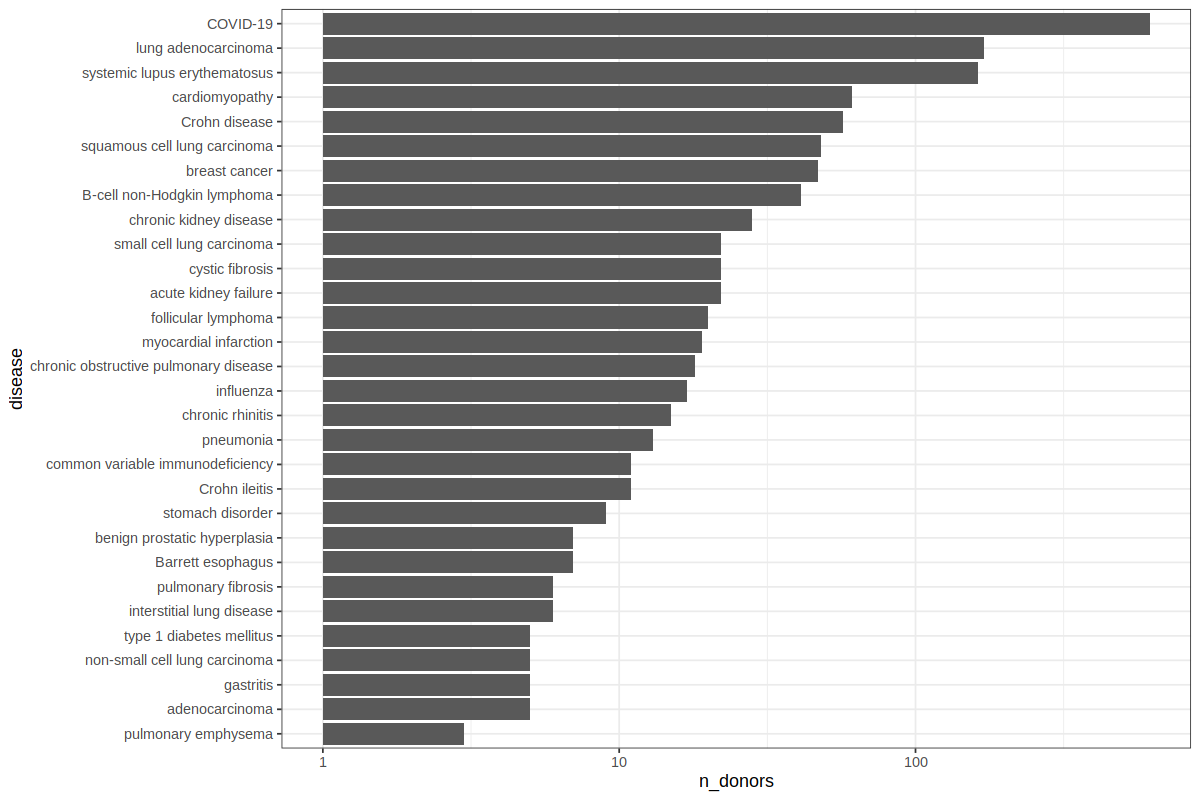

In [272]:
%%R -i df  -w 1200 -h 800
pl_df <- df %>%
    filter(disease != 'normal') %>%
    filter(n_donors >= 3) %>%
    arrange(n_donors) %>%
    mutate(disease = factor(disease, levels=unique(disease))) 

keep_diseases <- levels(pl_df$disease) %>% as.character()
    
pl_df %>%
    ggplot(aes(disease, n_donors)) +
    geom_col() +
    coord_flip() +
    scale_y_log10() +
    theme_bw(base_size=18)

In [247]:
# %%R -w 1500 -h 1000 -o disease_order -i donors_by_tissue
# pl_df <- donors_by_tissue %>%
#     filter(disease %in% c(as.character(keep_diseases), 'normal')) %>%
#     group_by(tissue_general) %>%
#     mutate(n_diseases = n()) %>%
#     filter(!all(disease == 'normal')) %>%
#     ungroup() %>%
#     arrange(n_diseases) %>%
#     mutate(tissue_general = factor(tissue_general, levels=unique(tissue_general))) %>%
#     arrange(tissue_general) %>%
#     mutate(disease = factor(disease, levels=c('normal', setdiff(rev(unique(disease)), c('normal'))))) %>%
#     mutate(text_color=ifelse(n_donors > 100, 'black', 'white')) 

# disease_order <- levels(pl_df$disease) %>% as.character()
    
# pl2 <- pl_df %>%
#     ggplot(aes(tissue_general, disease)) +
#     geom_tile(aes(fill=log10(n_donors))) +
#     geom_text(aes(label=n_donors, color=text_color)) +
#     scale_fill_viridis_c() +
#     scale_color_manual(values=c(white='white', black='black')) +
#     guides(color='none') +
#     theme_bw(base_size=22) +
#     theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) 
    
# pl2

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


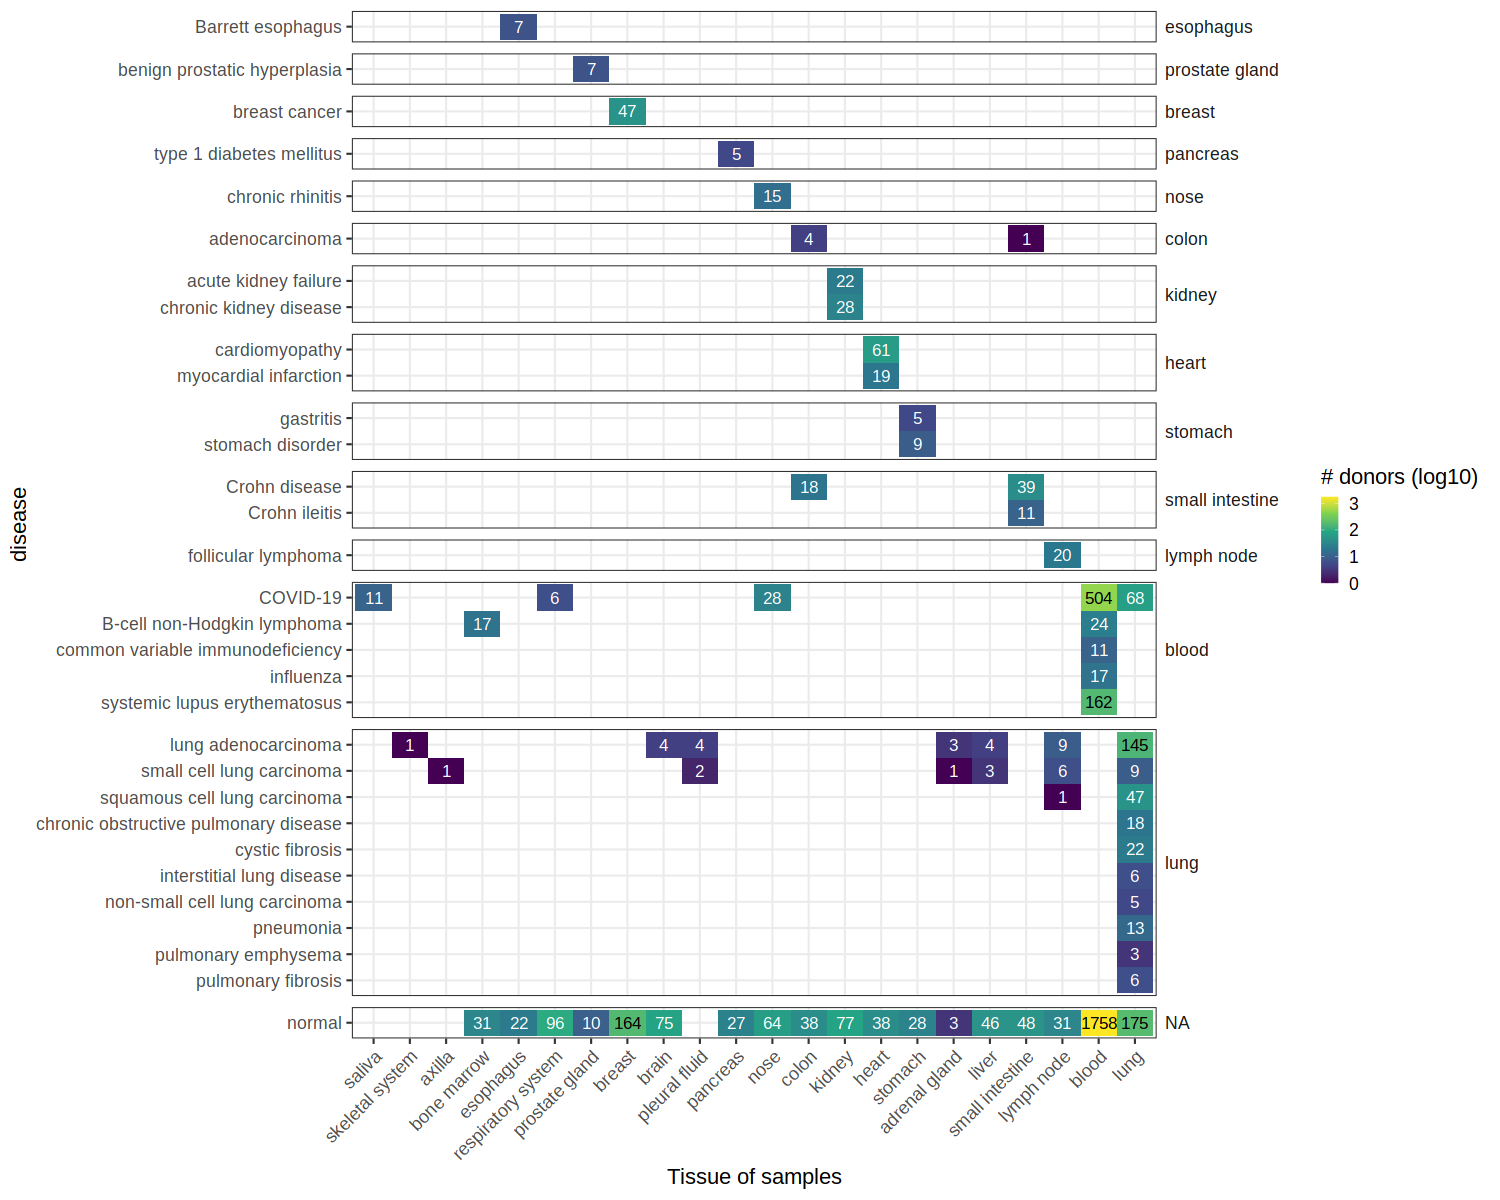

In [275]:
%%R -w 1500 -h 1200 -o disease_order -i donors_by_tissue
pl_df <- donors_by_tissue %>%
    filter(disease %in% c(as.character(keep_diseases), 'normal')) %>%
    group_by(tissue_general) %>%
    mutate(n_diseases = n()) %>%
    filter(!all(disease == 'normal')) %>%
    ungroup() %>%
    arrange(n_diseases) %>%
    mutate(tissue_general = factor(tissue_general, levels=unique(tissue_general))) %>%
    mutate(disease_relevant_tissue = factor(disease_relevant_tissue, levels=levels(tissue_general))) %>%
    arrange(tissue_general) %>%
    mutate(disease = factor(disease, levels=c('normal', setdiff(rev(unique(disease)), c('normal'))))) %>%
    mutate(text_color=ifelse(n_donors > 100, 'black', 'white')) 

disease_order <- levels(pl_df$disease) %>% as.character()
    
pl2 <- pl_df %>%
    ggplot(aes(tissue_general, disease)) +
    geom_tile(aes(fill=log10(n_donors))) +
    geom_text(aes(label=n_donors, color=text_color), size=6) +
    scale_fill_viridis_c(name='# donors (log10)') +
    scale_color_manual(values=c(white='white', black='black')) +
    guides(color='none') +
    xlab('Tissue of samples') +
    theme_bw(base_size=22) +
        facet_grid(disease_relevant_tissue~., space='free', scales='free') +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1), strip.text.y = element_text(angle=0, hjust=0), strip.background=element_blank()) 

    pl2 + 
    ggsave('../data/plots/disease_tissue_heatmap.pdf', width=18, height=13) +
    ggsave('../data/plots/disease_tissue_heatmap.png', width=18, height=13)

Stats on number of donors

In [284]:
dr_tissues = donors_by_tissue['disease_relevant_tissue'].unique()

In [311]:
normal_df = donors_by_tissue[(donors_by_tissue['tissue_general'].isin(dr_tissues)) & (donors_by_tissue.disease =='normal')]
normal_df = normal_df[['n_donors', 'tissue_general']].copy()
normal_df.columns = ['n_donors_normal', 'disease_relevant_tissue']
disease_df = donors_by_tissue[(donors_by_tissue['tissue_general'] == donors_by_tissue.disease_relevant_tissue) & (donors_by_tissue.disease !='normal')]
df = pd.merge(disease_df, normal_df)

normal_df.n_donors_normal.median()

38.0

In [312]:
disease_df.n_donors.median()

16.0

### For which disease-relevant tissues do we have single-cell data?

In [105]:
# donors_by_tissue = donors_by_tissue[donors_by_tissue.disease=='normal']
donors_by_tissue['disease_relevant'] = donors_by_tissue['tissue_general'].isin(relevant_tissue_annotation.keys())

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


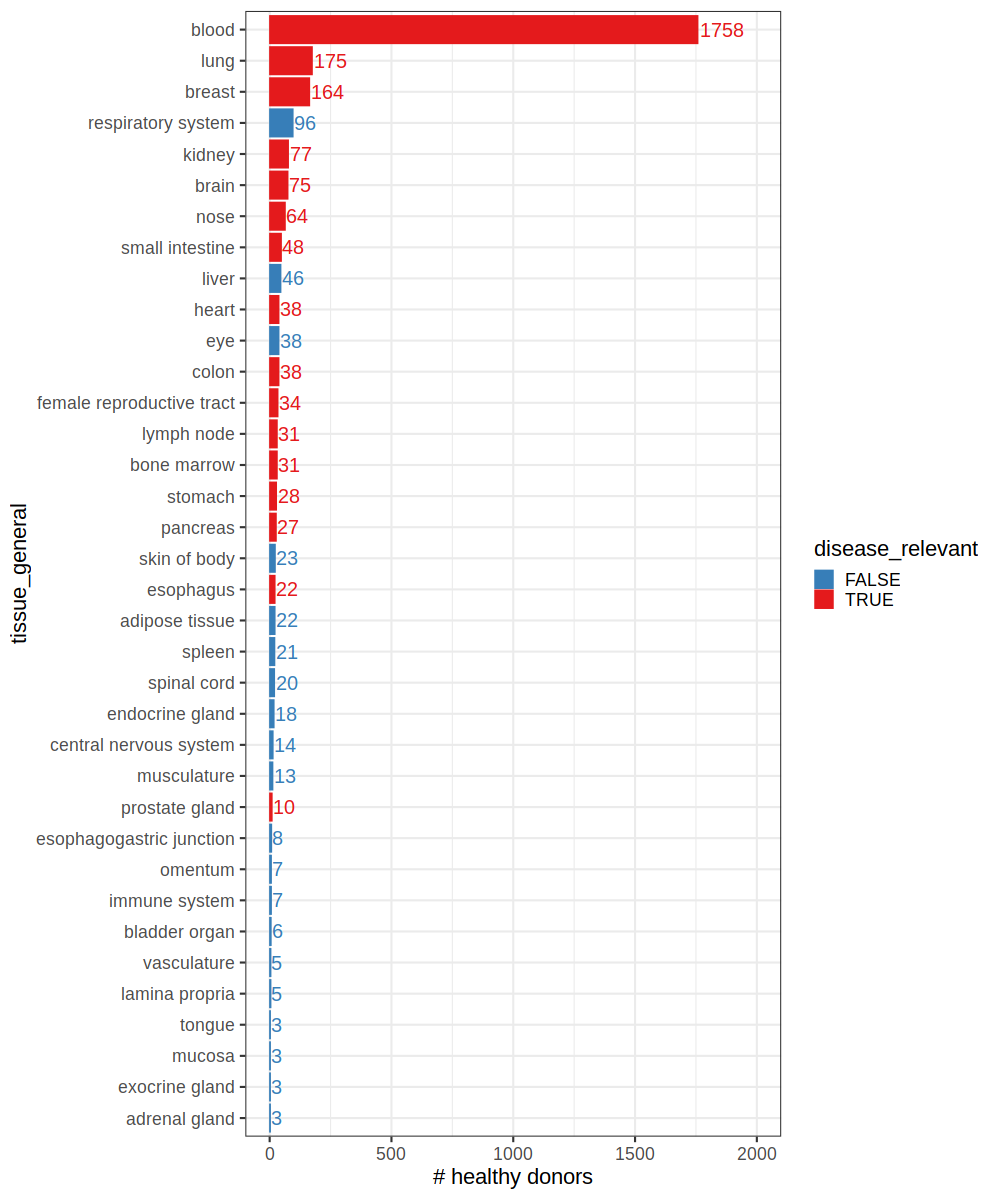

In [106]:
%%R -i donors_by_tissue -w 1000 -h 1200
donors_by_tissue %>% 
filter(disease == 'normal') %>%
filter(n_donors >= 3) %>%
arrange(n_donors) %>%
mutate(tissue_general = factor(tissue_general, unique(tissue_general))) %>%
ggplot(aes(tissue_general, n_donors, fill=disease_relevant, color=disease_relevant)) +
geom_col() +
geom_text(aes(label=n_donors), size=7, hjust=-.05) +
scale_fill_brewer(palette='Set1', direction=-1) +
scale_color_brewer(palette='Set1', direction=-1) +
ylim(0,2000) +
ylab('# healthy donors') +
# facet_grid(disease_relevant~., space='free', scale='free') +
# scale_y_log10() +
coord_flip() +
theme_bw(base_size=22)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


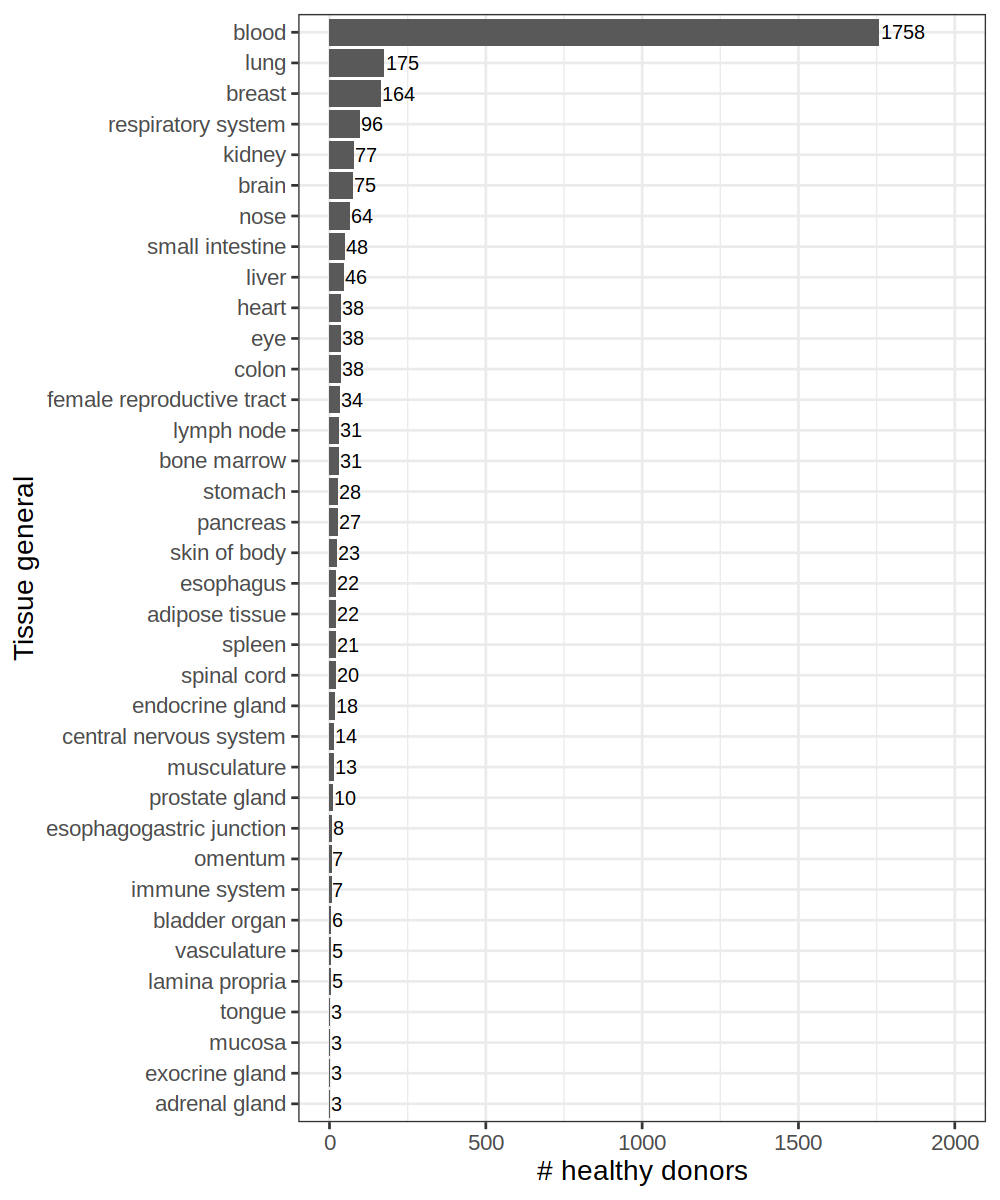

In [107]:
%%R -i donors_by_tissue -w 1000 -h 1200
donors_by_tissue %>% 
filter(disease == 'normal') %>%
filter(n_donors >= 3) %>%
arrange(n_donors) %>%
mutate(tissue_general = factor(tissue_general, unique(tissue_general))) %>%
ggplot(aes(tissue_general, n_donors)) +
geom_col() +
geom_text(aes(label=n_donors), size=7, hjust=-.05) +
scale_fill_brewer(palette='Set1', direction=-1) +
scale_color_brewer(palette='Set1', direction=-1) +
ylim(0,2000) +
ylab('# healthy donors') +
xlab("Tissue general") +
# facet_grid(disease_relevant~., space='free', scale='free') +
# scale_y_log10() +
coord_flip() +
theme_bw(base_size=28) +
ggsave("~/figure_hca_gm.png") 

### What is the overlap between drug indications in OT and available sc data?

In [108]:
# Read cxg metadata
cxg_hsapiens = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)
donors_by_tissue = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_by_tissue.disease_relevant_annotation.csv', index_col=0)
cxg_hsapiens.loc[:, 'disease_ontology_id'] = cxg_hsapiens.disease_ontology_id.str.replace(':',"_")

In [110]:
# Read OT targets table (all targets, not only with disease indication)
ot_table = pd.read_csv('../data/TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.csv', index_col=0)
ot_disease_info = pd.read_csv('../data/DiseasesInformation_OpenTargets_06092023.csv', index_col=0)

In [111]:
all_diseases = ot_disease_info['name'].astype(str).unique()

In [112]:
import ast
all_disease_ids = sum([ast.literal_eval(x) for x in ot_disease_info.therapeuticAreas.tolist()], [])

In [113]:
disease_ids = ot_table.diseaseId.unique()
cxg_hsapiens[cxg_hsapiens.disease_ontology_id.str.replace(':',"_").isin(disease_ids)]['disease'].unique()

array(['breast cancer', 'COVID-19', 'cystic fibrosis', 'chronic rhinitis',
       'dementia', 'pilocytic astrocytoma', 'gastric cancer',
       'common variable immunodeficiency', 'glioblastoma',
       'Crohn ileitis', 'follicular lymphoma', 'acute kidney failure',
       'systemic lupus erythematosus', 'Alzheimer disease',
       'type 1 diabetes mellitus'], dtype=object)

In [114]:
import obonet
import networkx
# mondo_id = 'MONDO:0012419'
flu_efo = 'EFO:0007328'

# obo_file = "./data/efo.obo"  # downloaded from http://obofoundry.org/ontology/ebo.html

# Load the ontology from the OBO file
EFO_GRAPH = obonet.read_obo('https://www.ebi.ac.uk/efo/efo.obo')


In [115]:
def get_MONDO_from_EFO(efo_id):
    if '_' in efo_id:
        efo_id = efo_id.replace('_', ":")
    try:
        synonyms = EFO_GRAPH.nodes[efo_id]['xref']
    except KeyError:
#         print('No matching MONDO id')
        return efo_id
    mondo_ids = [x for x in synonyms if x.startswith('MONDO:')]
    if len(mondo_ids) > 1:
        print("multiple MONDO matches - returning first instance")
    elif len(mondo_ids) < 1:
#         print('No matching MONDO id')
        return efo_id
    return(mondo_ids[0])

In [117]:
ot_disease_info = pd.read_csv('../data/DiseasesInformation_OpenTargets_06092023.csv', index_col=0)
ot_disease_info['cxg_matched_id'] = [get_MONDO_from_EFO(x['id']) if x['id'].startswith('EFO') else x['id'] for i, x in ot_disease_info.iterrows()]
ot_disease_info['cxg_matched_id'] = [x.replace(':', "_") for x in ot_disease_info['cxg_matched_id']]

multiple MONDO matches - returning first instance
multiple MONDO matches - returning first instance
multiple MONDO matches - returning first instance


In [119]:
ot_disease_info.to_csv('../data/DiseasesInformation_OpenTargets_10122023.csv')

In [120]:
cxg_hsapiens = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)
cxg_disease_ids = cxg_hsapiens[['disease','disease_ontology_id']].drop_duplicates()
cxg_disease_ids['disease_ontology_id'] = [x.replace(":", "_") for x in cxg_disease_ids['disease_ontology_id']]
cxg_disease_ids.disease_ontology_id.isin( ot_disease_info['cxg_matched_id'] ).value_counts()

True     40
False     1
Name: disease_ontology_id, dtype: int64

### For how many indications do we have data from the healthy "affected tissue" but not the disease data?

In [134]:
ot_table =  pd.read_csv('../data/TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)

In [135]:
## Filter OT table to diseases in cxg
cxg_diseases = pd.Series(cxg_hsapiens['disease_ontology_id'].unique())
n_ot_diseases = ot_table.disease_ontology_id.nunique()
n_overlapping_diseases = ot_table.disease_ontology_id[ot_table.disease_ontology_id.isin(cxg_diseases.str.replace(":","_"))].nunique()

print(f"Tot OT diseases: {n_ot_diseases}")
print(f"Tot overlapping diseases: {n_overlapping_diseases}")

Tot OT diseases: 15075
Tot overlapping diseases: 39


Plot number of targets and targets with drug evidence in OT diseases (and successful targets)

In [136]:
ot_table = ot_table[ot_table.disease_ontology_id.isin(cxg_diseases.str.replace(":","_"))].copy()

In [146]:
cxg_hsapiens['disease_ontology_id'] = cxg_hsapiens['disease_ontology_id'].str.replace(':',"_")

In [147]:
n_targets = ot_table.groupby('disease_ontology_id').size().reset_index()
n_targets.columns = ['disease_ontology_id', 'n_targets']

n_targets_drug = ot_table[ot_table['known_drug'] > 0].groupby('disease_ontology_id').size().reset_index()
n_targets_drug.columns = ['disease_ontology_id', 'n_drug_targets']

n_targets_drug_success = ot_table[ot_table['is_effective'] == 1].groupby('disease_ontology_id').size().reset_index()
n_targets_drug_success.columns = ['disease_ontology_id', 'n_success_drug_targets']

n_targets_df = pd.merge(n_targets, n_targets_drug, how='left')
n_targets_df = pd.merge(n_targets_df, n_targets_drug_success, how='left')

n_targets_df = pd.merge(n_targets_df, cxg_hsapiens[['disease_ontology_id', 'disease_name_original', 'disease_relevant_tissue']].drop_duplicates(), how='left')
n_targets_df = n_targets_df.fillna(0)
n_targets_df

,disease_ontology_id,n_targets,n_drug_targets,n_success_drug_targets,disease_name_original,disease_relevant_tissue
0,MONDO_0000709,125,0.0,0.0,Crohn ileitis,small intestine
1,MONDO_0001056,374,187.0,66.0,gastric cancer,stomach
2,MONDO_0001627,28,0.0,0.0,dementia,brain
3,MONDO_0002492,1132,8.0,5.0,acute kidney failure,kidney
4,MONDO_0002771,1393,21.0,13.0,pulmonary fibrosis,lung
5,MONDO_0004298,185,0.0,0.0,stomach disorder,stomach
6,MONDO_0004514,34,0.0,0.0,chronic rhinitis,nose
7,MONDO_0004849,777,22.0,12.0,pulmonary emphysema,lung
8,MONDO_0004966,52,8.0,2.0,gastritis,stomach
9,MONDO_0004970,2754,135.0,5.0,adenocarcinoma,colon


In [148]:
n_targets_df = n_targets_df.convert_dtypes()

In [149]:
n_targets_df['n_targets'] = n_targets_df['n_targets'].astype('float')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


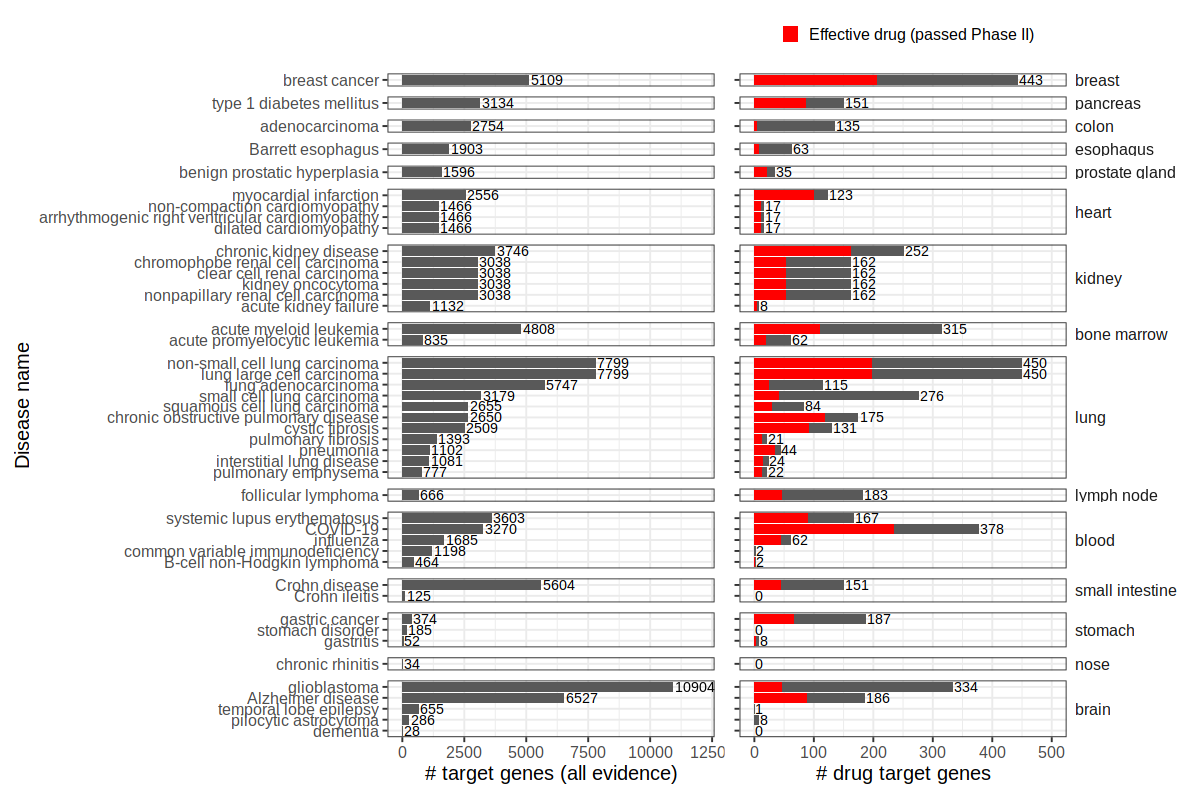

In [150]:
%%R -i n_targets_df -w 1200 -h 800

pl_df <- n_targets_df %>%
arrange(n_targets) %>%
mutate(
    disease_name_original = factor(disease_name_original, levels=unique(disease_name_original)),
    disease_relevant_tissue = factor(disease_relevant_tissue, levels=rev(unique(disease_relevant_tissue)))
) 

pl1 <- pl_df %>%
    ggplot(aes(disease_name_original, n_targets)) +
    geom_col() +
    geom_text(aes(label=n_targets), size=5, hjust=-.05) +
    coord_flip() +
    theme_bw(base_size=20) +
    facet_grid(disease_relevant_tissue~., space='free', scales='free') +
    theme(strip.text.y = element_blank(), strip.background=element_blank()) +
    xlab("Disease name") + ylab("# target genes (all evidence)") +
    ylim(0,12000)
    
pl2 <- pl_df %>%
    ggplot(aes(disease_name_original, n_drug_targets)) +
    geom_col() +
    geom_text(aes(label=n_drug_targets), size=5, hjust=-.05) +
    geom_col(aes(y=n_success_drug_targets, fill='Effective drug (passed Phase II)')) +
    scale_fill_manual(values='red', name='') +
    coord_flip() +
    theme_bw(base_size=20) +
    ylab("# drug target genes") +
        ylim(0,500) +
    facet_grid(disease_relevant_tissue~., space='free', scales='free') +
    theme(axis.text.y = element_blank(), axis.title.y = element_blank(), legend.position='top',
          strip.background=element_blank(), strip.text.y = element_text(angle=0, hjust=0)) 

    
(pl1 + pl2) +
ggsave('/home/jovyan/mount/gdrive/sc_targetID/plots/OT_evidence_barplot.png', width=15, height=12) +
ggsave('/home/jovyan/mount/gdrive/sc_targetID/plots/OT_evidence_barplot.pdf', width=15, height=12)

In [151]:
drug_score_class = {
    'druggable': 0,
    'safe': 0.1,
    'effective': 0.2,
    'approved': 0.7
}

In [152]:
ot_table['drug_phase'] = pd.cut(ot_table.known_drug, [0, 0.05, 0.1, 0.2, 0.7, 1], include_lowest=False, labels = ['early phase I', 'phase I', 'phase II', 'phase III', 'approved'])

In [154]:
n_drug_phase = ot_table.groupby(['disease_ontology_id', 'drug_phase']).size().reset_index()
n_drug_phase.columns = ['disease_ontology_id','drug_phase', 'n_targets']
n_drug_phase_df = pd.merge(n_drug_phase, cxg_hsapiens[['disease_ontology_id', 'disease_name_original', 'disease_relevant_tissue']].drop_duplicates(), how='left')
n_drug_phase_df = n_drug_phase_df.fillna(0)
n_drug_phase_df

,disease_ontology_id,drug_phase,n_targets,disease_name_original,disease_relevant_tissue
0,MONDO_0000709,early phase I,0,Crohn ileitis,small intestine
1,MONDO_0000709,phase I,0,Crohn ileitis,small intestine
2,MONDO_0000709,phase II,0,Crohn ileitis,small intestine
3,MONDO_0000709,phase III,0,Crohn ileitis,small intestine
4,MONDO_0000709,approved,0,Crohn ileitis,small intestine
...,...,...,...,...,...
220,MONDO_0100096,early phase I,0,COVID-19,blood
221,MONDO_0100096,phase I,24,COVID-19,blood
222,MONDO_0100096,phase II,119,COVID-19,blood
223,MONDO_0100096,phase III,173,COVID-19,blood


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


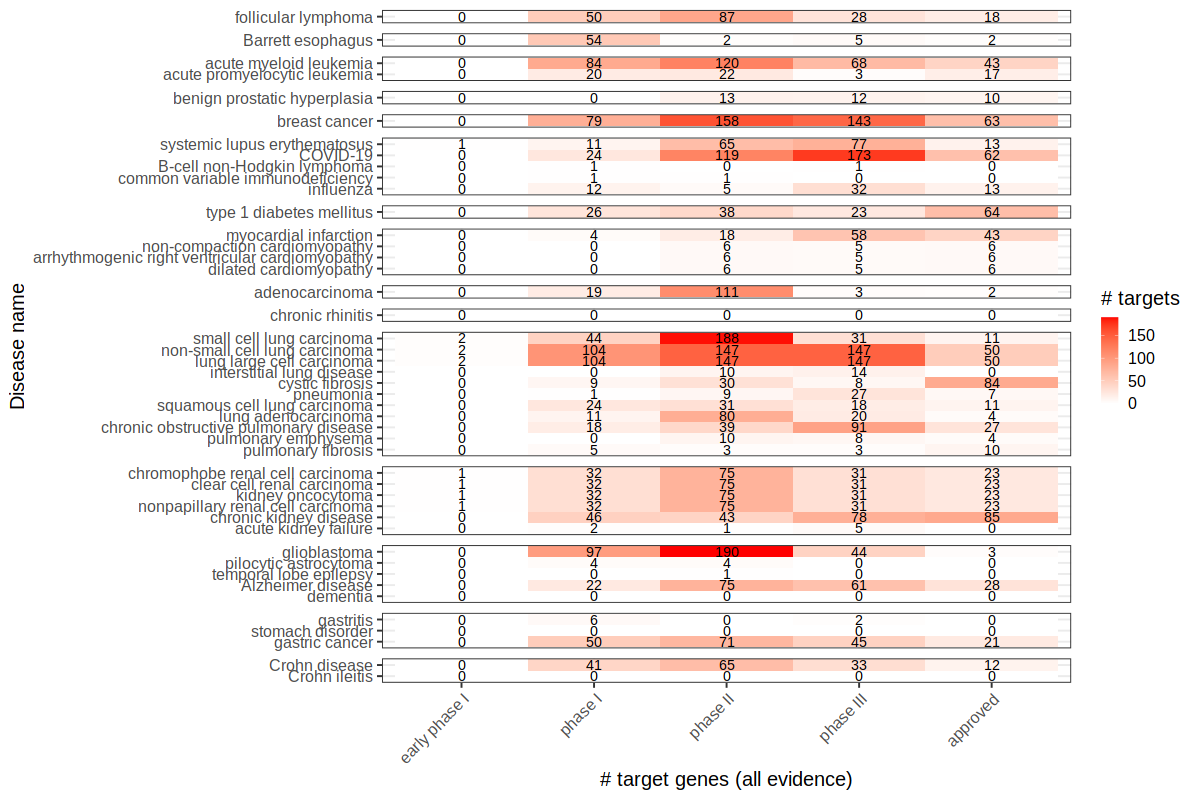

In [155]:
%%R -i n_drug_phase_df -w 1200 -h 800

pl_df <- n_drug_phase_df %>%
arrange(n_targets) %>%
mutate(
    disease_name_original = factor(disease_name_original, levels=unique(disease_name_original)),
    disease_relevant_tissue = factor(disease_relevant_tissue, levels=rev(unique(disease_relevant_tissue)))
) 

pl1 <- pl_df %>%
    ggplot(aes(disease_name_original, drug_phase, fill=n_targets)) +
    geom_tile() +
    geom_text(aes(label=n_targets), size=5) +
    coord_flip() +
    theme_bw(base_size=20) +
    facet_grid(disease_relevant_tissue~., space='free', scales='free') +
    scale_fill_gradient(low = "white", high = "red", name='# targets') +
    theme(strip.text.y = element_blank(), strip.background=element_blank(), axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    xlab("Disease name") + ylab("# target genes (all evidence)") 
pl1 +
    ggsave('/home/jovyan/mount/gdrive/sc_targetID/plots/OT_drug_phase.png', width=10, height=12) +
    ggsave('/home/jovyan/mount/gdrive/sc_targetID/plots/OT_drug_phase.pdf', width=10, height=12)

In [156]:
drug_score_class = {
    'druggable': 0,
    'safe': 0.1,
    'effective': 0.2,
    'approved': 0.7
}

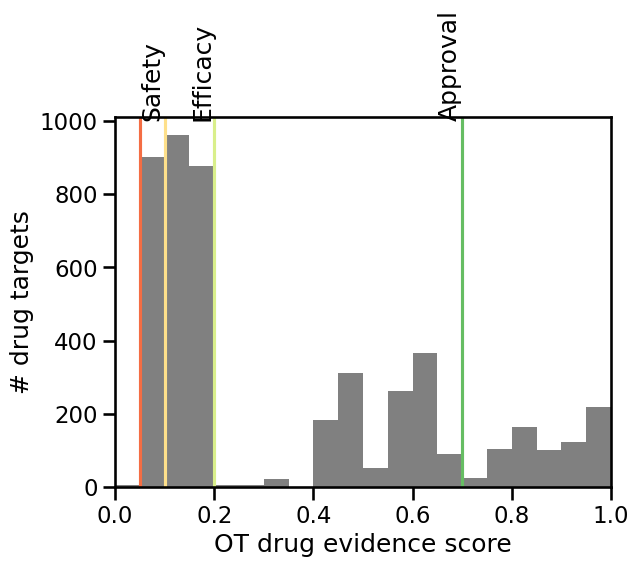

In [157]:
sns.set_context('talk');
plt.hist(ot_table['known_drug'][ot_table['known_drug'] > 0], bins=np.arange(0,1.05, 0.05), color='grey');
plt.axvline(0.05, color=sns.color_palette("RdYlGn", 4)[0], label='Druggability');
plt.axvline(0.1,  color=sns.color_palette("RdYlGn", 4)[1], label = 'Safety');
plt.axvline(0.2,  color=sns.color_palette("RdYlGn", 4)[2], label = 'Efficacy');
plt.axvline(0.7, color=sns.color_palette("RdYlGn", 4)[3], label = 'Approval');
# plt.text(0.05, 1000, 'Druggability', rotation=90, color='black',    va='bottom', ha='right')
plt.text(0.1, 1000, 'Safety', rotation=90,        color='black',    va='bottom', ha='right')
plt.text(0.2, 1000, 'Efficacy', rotation=90,      color='black',    va='bottom', ha='right')
plt.text(0.7, 1000, 'Approval', rotation=90,     color='black',    va='bottom', ha='right')
plt.xlim(0,1.0);
plt.ylabel('# drug targets');
plt.xlabel('OT drug evidence score');


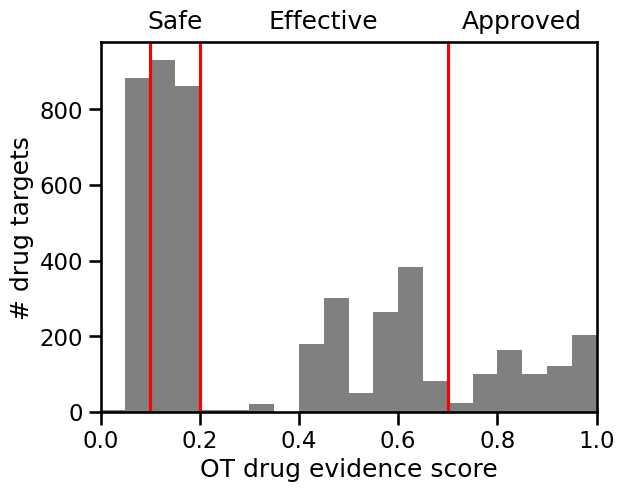

In [259]:
sns.set_context('talk');
plt.hist(ot_table['known_drug'][ot_table['known_drug'] > 0], bins=np.arange(0,1.05, 0.05), color='grey');
plt.axvline(0.1,  color='red', label='in Phase I');
plt.axvline(0.2,  color='red', label = 'in Phase II');
plt.axvline(0.7,  color='red', label = 'in Phase III');

plt.text(0.15, 1000, 'Safe'  ,    color='black',    va='bottom', ha='center');
plt.text(0.45, 1000, 'Effective', color='black',    va='bottom', ha='center');
plt.text(((1 - 0.7)/2) + 0.7, 1000, 'Approved',   color='black',    va='bottom', ha='center');

plt.xlim(0,1.0);
plt.ylabel('# drug targets');
plt.xlabel('OT drug evidence score');


Save MONDO IDs for overlapping disease for pseudo-bulking

In [244]:
all_cxg_diseases = ot_table.cxg_matched_id.str.replace("_",":").unique().tolist()

file_path = "./data/all_diseaseIDs.txt"
with open(file_path, "w") as file:
    for item in all_cxg_diseases:
        file.write(str(item) + "\n")

---

In [247]:
disease_ontology_id = 'MONDO:0005575'

ot_table.cxg_matched_id[ot_table.cxg_matched_id == 'MONDO_0005575']

57         MONDO_0005575
170        MONDO_0005575
2339       MONDO_0005575
3589       MONDO_0005575
3988       MONDO_0005575
               ...      
2042932    MONDO_0005575
2042936    MONDO_0005575
2043070    MONDO_0005575
2043227    MONDO_0005575
2044393    MONDO_0005575
Name: cxg_matched_id, Length: 4239, dtype: object